### References:
 -    https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/
 -    https://pythonhosted.org/dautil/ts.html
 -    https://www.datahubbs.com/forecasting-with-seasonality
![title](img/exponential_smooth.png) 

In [6]:
import calendar
from datetime import datetime
from dateutil.relativedelta import *

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn import linear_model
#from sklearn.linear_models import LinearRegression
#import dautil as dl


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from dateutil import parser

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
#from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10, 6

## Load Time-series data from website
 - compute and display the moving average

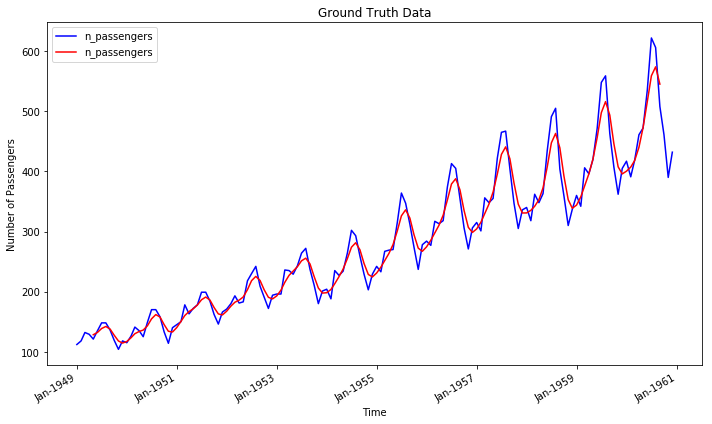

In [5]:
df_pass = pd.read_csv('https://raw.githubusercontent.com/dacatay/time-series-analysis/master/data/passengers.csv',\
                      sep=';', header='infer', parse_dates = [0], infer_datetime_format = True,
                      date_parser = pd.to_datetime)  #dtype=dtypes, names=my_header_names, 

df_pass.set_index("month", inplace = True)

df_mavg = df_pass.rolling(8, win_type='parzen', center = True).mean()
df_mavg.dropna(subset=['n_passengers'], inplace = True)

#display(df_pass.head(10))

fig1,ax1 = plt.subplots(figsize=(10,6))
df_pass.plot(ax = ax1, color='blue', x_compat=True)
df_mavg.plot(ax = ax1, color='red', x_compat=True)
myFmt = mdates.DateFormatter('%b-%Y')
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_title('Ground Truth Data')
ax1.set_ylabel("Number of Passengers")
ax1.set_xlabel("Time")

plt.tight_layout()
plt.show()

## Simulate some Data Drop Outs

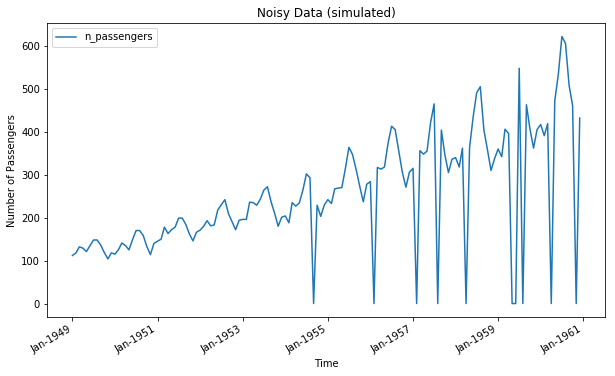

In [337]:
remove_n = 10
df_sim = df_pass.copy(deep = True)

drop_indices = np.random.choice(df_sim.index, remove_n, replace=False)
df_sim.loc[drop_indices,:] = 0

fig2, ax2 = plt.subplots(figsize=(10,6))
df_sim.plot(ax = ax2, x_compat=True)
myFmt = mdates.DateFormatter('%b-%Y')
ax2.xaxis.set_major_formatter(myFmt)

ax2.set_title("Noisy Data (simulated)")
ax2.set_ylabel("Number of Passengers")
ax2.set_xlabel("Time")
plt.show()

## Interpolate to remove Data Drop Outs
-  indexing can also be accomplished via: <br>
```   
         pd.Timestamp("2006-01-03 00:00:00")
or 
         gs.loc[pd.Timestamp("2006-01-01 00:00:00"):pd.Timestamp("2007-12-31 11:59:59") ]
         
freq = "MS" - pandas defaults to end of month. S tells pandas to give you start of month.
```

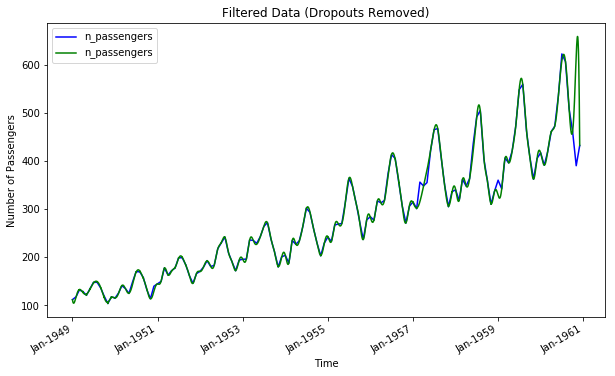

<Figure size 432x288 with 0 Axes>

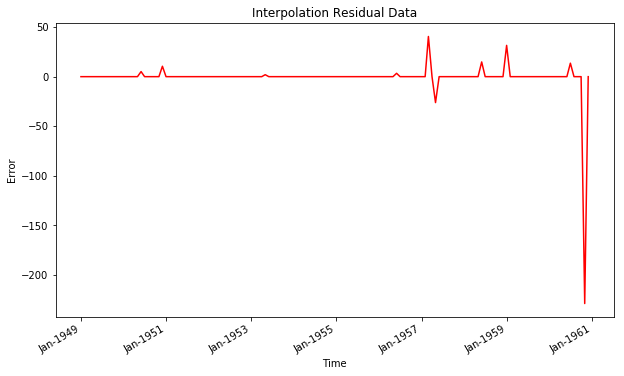

MSE 1.6458567354597047


In [310]:
# change the drop outs to Nan's
df_sim[df_sim["n_passengers"]==0] = np.nan

new_index = pd.date_range(df_sim.index[0], df_sim.index[-1], freq = 'D')
df_interp = df_sim.reindex(new_index)

df_interp = df_interp.interpolate(method='spline', order=5)

fig3, ax3 = plt.subplots(figsize=(10,6))
df_pass.plot(ax = ax3, color='blue', x_compat=True)
df_interp.plot(ax = ax3, color = 'green', x_compat=True)
myFmt = mdates.DateFormatter('%b-%Y')
ax3.xaxis.set_major_formatter(myFmt)

ax3.set_title("Filtered Data (Dropouts Removed)")
ax3.set_ylabel("Number of Passengers")
ax3.set_xlabel("Time")
plt.show()

plt.tight_layout()
plt.show()

# Plot the residual

#df_residual = df_sim.copy(deep = True)
df_residual = pd.merge(df_pass, df_interp, right_index=True, left_index=True, how = "left")
df_residual['resid'] = df_residual['n_passengers_x'] - df_residual['n_passengers_y']
df_residual['e_square'] = df_residual['resid']**2

fig4, ax4 = plt.subplots(figsize=(10,6))
df_residual['resid'].plot(ax = ax4, color='red', x_compat=True)
myFmt = mdates.DateFormatter('%b-%Y')
ax4.xaxis.set_major_formatter(myFmt)

ax4.set_title("Interpolation Residual Data")
ax4.set_ylabel("Error")
ax4.set_xlabel("Time")
plt.show()

print("MSE", 1/float(len(df_residual.index))*np.sqrt(df_residual['e_square'].sum()))

## TSA = Time Series Analysis
### Box-Jenkins ARIMA
model where the prediction is a weighted linear sum of recent past observations or lags.

### Exponential Smoothing methods
Forecasts produced using exponential smoothing methods are weighted averages of past observations, with the weights decaying exponentially as the observations get older. In other words, the more recent the observation the higher the associated weight.


BLUF: Prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations.

— See Page 171, Forecasting: principles and practice, https://otexts.org/fpp2/ 2013.

### Holt Winters ARIMA
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

### Pandas EWMA

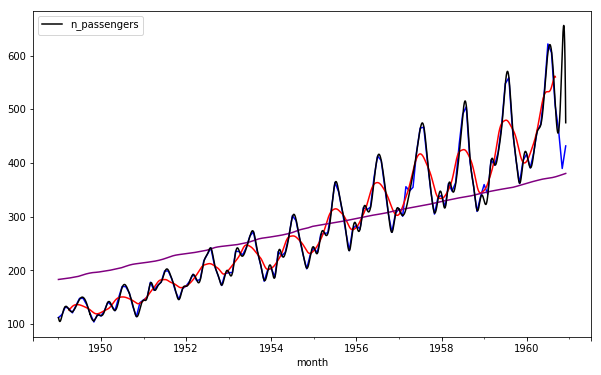

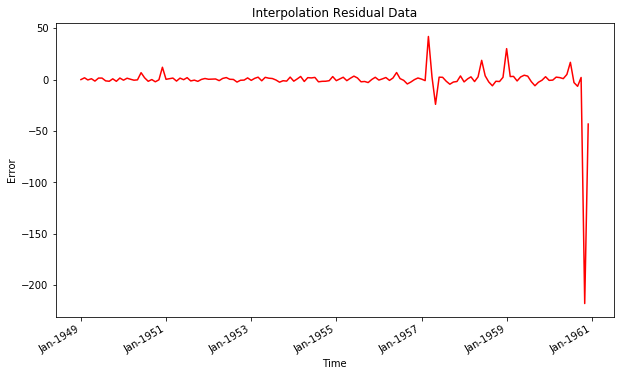

<Figure size 432x288 with 0 Axes>

Optimal Alpha:   0.36 Minimum MSE:   1.6129850513835078


In [311]:
fig5, ax5 = plt.subplots(figsize=(10,6))
df_pass["n_passengers"].plot(ax = ax5, label = 'RAW', color = 'blue')
df_interp["n_passengers"].rolling(180, center = True).mean().plot(ax = ax5, label = "180-D moving avergage", color = 'red')
df_interp["n_passengers"].expanding(min_periods = 1, center = True).mean().plot(ax = ax5, label = "expanding avergage", color = 'purple')

mse_dict = defaultdict(lambda: 0)
for alpha_i in map(lambda x: x/100.0, range(1, 100, 5)):
    df_residual = pd.DataFrame()
    df_ewm = pd.DataFrame(index=df_interp.index, columns=["n_passengers"])
    df_ewm = df_interp["n_passengers"].ewm(alpha = alpha_i).mean()
    df_ewm = df_ewm.reset_index()
    df_ewm.columns = ['month', 'n_passengers']
    df_ewm['month'] = pd.to_datetime(df_ewm['month'], format='%Y-%m-%d')
    df_ewm.set_index("month", inplace = True)
    
    # Compute the residual
    df_residual = pd.merge(df_pass, df_ewm, right_index=True, left_index=True, how = "left")
    df_residual['resid'] = df_residual['n_passengers_x'] - df_residual['n_passengers_y']

    df_residual['e_square'] = df_residual['resid']**2
    mse_dict[alpha_i] = 1/float(len(df_residual.index))*np.sqrt(df_residual['e_square'].sum())
    
alpha_star = min(mse_dict, key=mse_dict.get)

df_ewm = pd.DataFrame(index=df_interp.index, columns=["n_passengers"])
df_ewm = df_interp["n_passengers"].ewm(alpha = alpha_star).mean()
df_ewm = df_ewm.reset_index()
df_ewm.columns = ['month', 'n_passengers']
df_ewm['month'] = pd.to_datetime(df_ewm['month'], format='%Y-%m-%d')
df_ewm.set_index("month", inplace = True)

df_ewm.plot(ax = ax5, label = "EWMA avergage", color = 'k')


# Plot the residual
#df_residual = df_sim.copy(deep = True)
df_residual = pd.DataFrame()
df_residual = pd.merge(df_pass, df_ewm, right_index=True, left_index=True, how = "left")
df_residual['resid'] = df_residual['n_passengers_x'] - df_residual['n_passengers_y']


fig6, ax6 = plt.subplots(figsize=(10,6))
df_residual['resid'].plot(ax = ax6, color='red', x_compat=True)
myFmt = mdates.DateFormatter('%b-%Y')
ax6.xaxis.set_major_formatter(myFmt)

ax6.set_title("Interpolation Residual Data")
ax6.set_ylabel("Error")
ax6.set_xlabel("Time")
plt.show()

plt.tight_layout()
plt.show()
print("Optimal Alpha:  ", alpha_star, "Minimum MSE:  ", mse_dict[alpha_star])

## Seasonality

<Figure size 432x288 with 0 Axes>

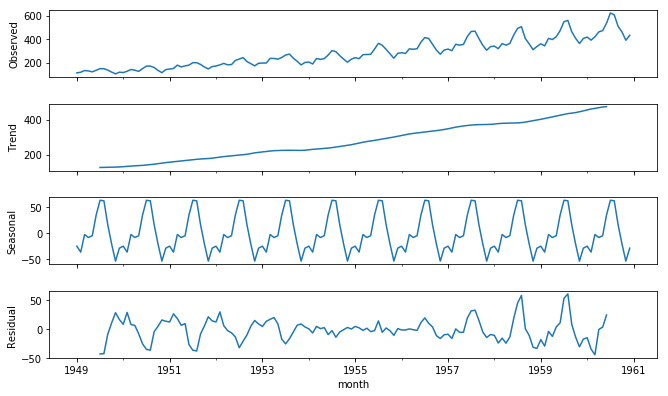

In [326]:
plt.figure()
smt.seasonal_decompose(df_pass).plot()
plt.gcf().set_size_inches(10, 6)
plt.show()

## Predict where you have data support in the current index
 - http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
 - https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                       n_passengers   No. Observations:                  144
Model:             SARIMAX(1, 0, 0)x(1, 1, 1, 12)   Log Likelihood                -508.997
Date:                            Mon, 22 Oct 2018   AIC                           1027.993
Time:                                    11:22:08   BIC                           1042.407
Sample:                                01-01-1949   HQIC                          1033.850
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.1452      0.063      2.323      0.020       0.023       0.268
ar.L1          0.7561      0.064   

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


' Or if you want to specify specific dates:\ndf_predict2 = df_pass.copy(deep = True)\ndf_predict2[\'forecast\'] = result.predict(start = pd.Timestamp("1959-01-01"),                                         end= pd.Timestamp("1961-01-01"),                                         dynamic= True)  \ndf_predict2[[\'n_passengers\', \'forecast\']].plot(figsize=(12, 8))\n\n'

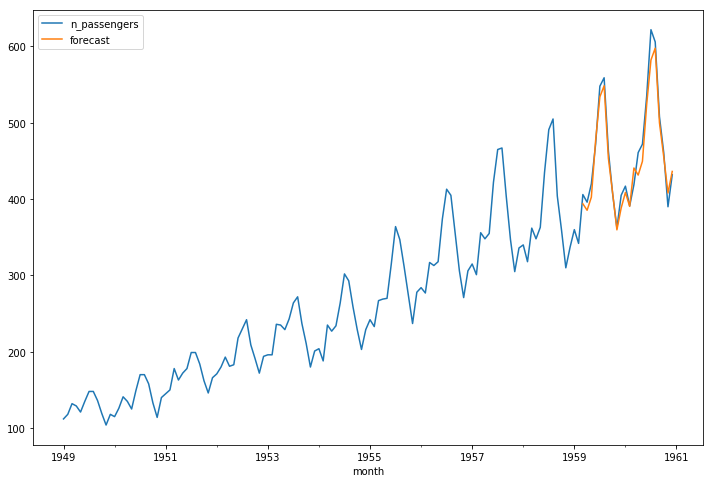

In [369]:
model = smt.SARIMAX(df_pass, trend = 't', order = (1,0,0), exog= None,\
                    seasonal_order=(1,1,1,12), simple_differencing=False)  # c: constant, t:linear, ct - linear + const
result = model.fit()
print(result.summary())

# Predict where you have data support in the current index

df_predict1 = df_pass.copy(deep = True)
df_predict1['forecast'] = result.predict(start = 122, end= 144, dynamic= True)  
df_predict1[['n_passengers', 'forecast']].plot(figsize=(12, 8))

""" Or if you want to specify specific dates:
df_predict2 = df_pass.copy(deep = True)
df_predict2['forecast'] = result.predict(start = pd.Timestamp("1959-01-01"),\
                                         end= pd.Timestamp("1961-01-01"),\
                                         dynamic= True)  
df_predict2[['n_passengers', 'forecast']].plot(figsize=(12, 8))

"""

## Future Forecasts

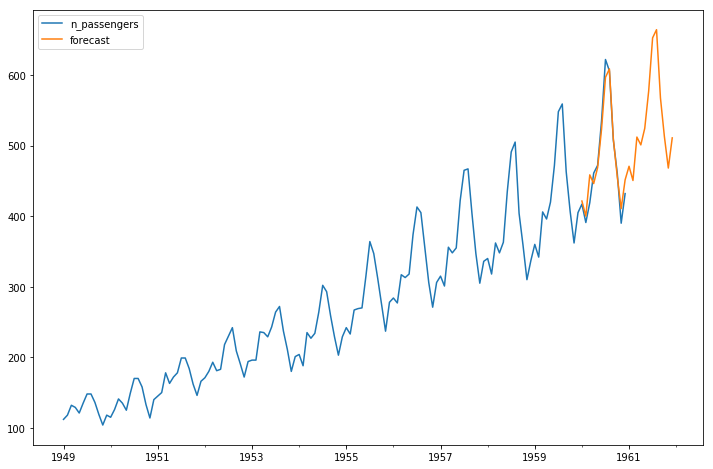

In [372]:
# create a set of indices taking you into the future.

start = datetime.strptime("1961-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,12)]
future = pd.DataFrame(index=date_list, columns= df_pass.columns)
df_FullFuture = pd.concat([df_pass, future])

df_FullFuture['forecast'] = result.predict(start = pd.Timestamp("1960-01-01"),\
                                           end = pd.Timestamp("1965-01-01"), dynamic= True)  
df_FullFuture[['n_passengers', 'forecast']].plot(figsize=(12, 8)) 
plt.savefig('exponential_smooth')

In [373]:
!ls

TimeSeries_InterpExtrap.ipynb exponential_smooth.png
